In [4]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import  match_astro_query_num, get_single_burn_elliptical_hohmann ,match_orbit_plane,  search_for_resonant_orbit


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [5]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)

callisto_ephem = Ephem.from_horizons(504,epochs= epochs, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

starship_orb=Orbit.from_classical(Jupiter, 1300000*u.km, 0.845*u.one, callisto_orb.inc, callisto_orb.raan, 0*u.deg, -10*u.deg,start_date,plane=Planes.EARTH_ECLIPTIC)
print(starship_orb.period.to(u.day))


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



9.575709772558454 d


In [6]:
##Working proof of multi orbit lamberts

# tof=30*u.day
# callisto_at_arrival=callisto_orb.propagate(tof)
# man=Maneuver.lambert(starship_orb, callisto_at_arrival, M=2)
# burn=man[0]
# dv=np.linalg.norm(burn[1])
# final_orb,dummy=starship_orb.apply_maneuver(man,intermediate=True)
# print(final_orb.period.to(u.day))
# print(dv)
# plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# plotter.plot(callisto_at_arrival.propagate(29*u.day), label="Callisto Orbit")
# plotter.plot(starship_orb, label="Starship Orbit")
# plotter.plot(final_orb.propagate(tof-29*u.day), label="Transfer Orbit")

In [7]:
transfer=get_single_burn_elliptical_hohmann(
    Callisto,
    starship_orb,
    tof_step=0.01*u.day,
    max_tof=60*u.day,
    max_revs=3
)
print(transfer[0])

Getting ephems from 2037-06-11 00:19:26.489.
44.16770364728937 m / s


In [17]:
starship_flyby_orbit=transfer[1].propagate(transfer[2].epoch)
callisto_flyby_orbit=transfer[2]

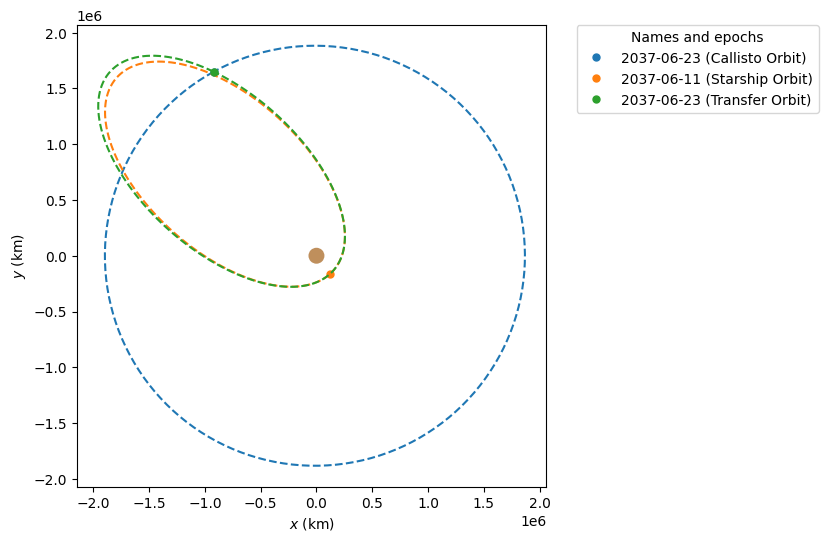

In [18]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(callisto_flyby_orbit, label="Callisto Orbit")
plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")

In [38]:
#return 
def possible_periods(spacecraft_orb, body_orb, body, r_p_min=10*u.km, r_p_max=5000*u.km, num_samples=500):#finds possible periods of orbit around attractor given flyby
    periods=np.zeros((num_samples,2))
    periaps=np.zeros((num_samples))
    attractor=spacecraft_orb.attractor
    if(np.linalg.norm(spacecraft_orb.r-body_orb.r))<2*body.R:
        rel_vel=spacecraft_orb.rv()[1]-body_orb.rv()[1]
        rel_speed=np.linalg.norm(rel_vel)
        r_ps = body.R + np.linspace(r_p_min.to(u.km).value, r_p_max.to(u.km).value, num=num_samples) * u.km
        rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
        # Rotation axis in ecliptic plane
        axis = np.array([0, 0, 1.0])
        axis = axis / np.linalg.norm(axis)
        # Try both rotation directions (leading/trailing side flybys)
        for j,sign in enumerate([1,-1]):
            for i, rot_ang in enumerate(rot_angs):
                # Rotate the relative velocity
                rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
                rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
                
                # Calculate post-assist velocity in attractor frame
                post_assist_vel = rel_vel_out + body_orb.rv()[1]
                
                # Create orbit from post-assist state
                test_orb = Orbit.from_vectors(
                    attractor, 
                    body_orb.r, 
                    post_assist_vel, 
                    spacecraft_orb.epoch,
                    plane=Planes.EARTH_ECLIPTIC
                )
                periods[i][j]=test_orb.period.to(u.day).value
                periaps[i]=r_ps[i].to(u.km).value
        return (periods,periaps)
                
                
    else:
        print(f"Trajectory does not fly past {body} closely enough")
        return periods

callisto_flyby_data=possible_periods(starship_flyby_orbit,callisto_flyby_orbit,Callisto,r_p_max=10000*u.km)

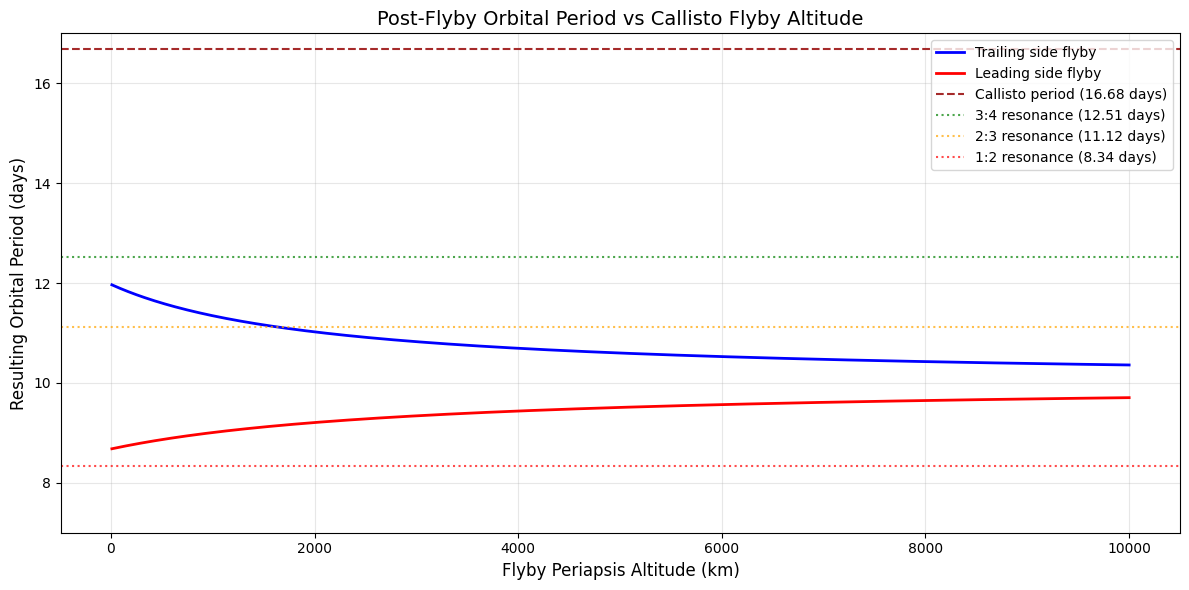

Callisto orbital period: 16.68 days

Trailing side flyby:
  Period range: 10.36 - 11.96 days

Leading side flyby:
  Period range: 8.68 - 9.70 days


In [39]:
# Plot period vs periapsis for both leading and trailing flybys
plt.figure(figsize=(12, 6))

periaps = callisto_flyby_data[1]-Callisto.R.to(u.km).value  # Periapsis altitudes
periods_trailing = callisto_flyby_data[0][:, 0]  # Trailing side (sign=1)
periods_leading = callisto_flyby_data[0][:, 1]  # Leading side (sign=-1)

plt.plot(periaps, periods_trailing, 'b-', label='Trailing side flyby', linewidth=2)
plt.plot(periaps, periods_leading, 'r-', label='Leading side flyby', linewidth=2)

# Add Callisto's orbital period as reference
callisto_period = callisto_orb.period.to(u.day).value
plt.axhline(y=callisto_period, color='brown', linestyle='--', 
            label=f'Callisto period ({callisto_period:.2f} days)', linewidth=1.5)

# Add resonance period references
plt.axhline(y=callisto_period * 3/4, color='green', linestyle=':', 
            label=f'3:4 resonance ({callisto_period * 3/4:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 2/3, color='orange', linestyle=':', 
            label=f'2:3 resonance ({callisto_period * 2/3:.2f} days)', linewidth=1.5, alpha=0.7)
plt.axhline(y=callisto_period * 1/2, color='red', linestyle=':', 
            label=f'1:2 resonance ({callisto_period * 1/2:.2f} days)', linewidth=1.5, alpha=0.7)

plt.xlabel('Flyby Periapsis Altitude (km)', fontsize=12)
plt.ylabel('Resulting Orbital Period (days)', fontsize=12)
plt.title('Post-Flyby Orbital Period vs Callisto Flyby Altitude', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.ylim(bottom=7,top=17)

plt.show()

# Print some statistics
print(f"Callisto orbital period: {callisto_period:.2f} days")
print(f"\nTrailing side flyby:")
print(f"  Period range: {periods_trailing.min():.2f} - {periods_trailing.max():.2f} days")
print(f"\nLeading side flyby:")
print(f"  Period range: {periods_leading.min():.2f} - {periods_leading.max():.2f} days")